In [88]:
import pandas as pd
import glob
import os

BASE_PATH = '/Users/anelyakurbanova/Downloads/predict-user-order'

action_type = pd.read_csv(f'{BASE_PATH}/action_type_info.csv')
widget_info = pd.read_csv(f'{BASE_PATH}/widget_info.csv')
products    = pd.read_csv(f'{BASE_PATH}/product_information.csv')
test_users  = pd.read_csv(f'{BASE_PATH}/test_users.csv')

actions_files = glob.glob(f'{BASE_PATH}/actions_history/*.parquet')
search_files  = glob.glob(f'{BASE_PATH}/search_history/*.parquet')

print("Amount of files from actions_history:", len(actions_files))
print("Amount of files from search_history:", len(search_files))


Amount of files from actions_history: 53
Amount of files from search_history: 32


Using this base path, I load the metadata tables:
- `action_type_info.csv` – mapping between action names and `action_type_id`,
- `widget_info.csv` – information about widgets,
- `product_information.csv` – product catalogue with prices and categories,
- `test_users.csv` – list of users for which predictions are required.

After that, I use `glob` to collect the full list of parquet files for the main logs:
- `actions_files` – all parts of `actions_history`,
- `search_files` – all parts of `search_history`.

In [89]:
import pandas as pd

sample_actions = pd.read_parquet(actions_files[0])
sample_search = pd.read_parquet(search_files[0])

print("sample_actions:", sample_actions.shape)
print("sample_search:", sample_search.shape)
sample_actions.head()

sample_actions: (2439286, 6)
sample_search: (2900172, 5)


,user_id,timestamp,product_id,page_product_id,action_type_id,widget_name_id
0,1043671,2024-07-20 10:13:59,1175359159,NaN,5,22
1,4635874,2024-06-28 12:43:45,804816676,NaN,5,22
2,6353819,2024-03-14 09:29:22,146649701,NaN,5,22
3,8929225,2024-06-03 15:42:17,284206046,NaN,5,22
4,3175727,2024-05-18 06:37:43,551356835,NaN,5,22


This quick exploratory step allows me to check:
- which columns are present,
- that timestamps are stored as integers in milliseconds,
- how `user_id`, `product_id`, `action_type_id` and `widget_name_id` look in the log.

# STEP 1. Determine ORDER_ACTION_ID from action_type_info.csv

In [90]:
action_type = pd.read_csv(f'{BASE_PATH}/action_type_info.csv')

order_row = action_type[action_type['action_type'].str.lower() == 'order']
if order_row.empty:
    raise ValueError("Could not find 'order' action in action_type_info.csv")

ORDER_ACTION_ID = int(order_row['action_type_id'].iloc[0])
print("ORDER_ACTION_ID:", ORDER_ACTION_ID)

ORDER_ACTION_ID: 3


In this step I programmatically determine the numeric `action_type_id` that corresponds to the "order" action.

I reload the `action_type_info.csv` table and search for the row where the `action_type` column is equal to `"order"` (case-insensitive). If such a row is not found, I explicitly raise an error to avoid silently building an incorrect target.

From the matching row I extract the value from the `action_type_id` column and store it in the variable `ORDER_ACTION_ID`. I also print this value to the notebook. In my dataset the ID for the "order" action is equal to `3`


# STEP 2. Target creation

In [91]:
users_active = set()
users_with_july_order = set()

for f in actions_files:
    df = pd.read_parquet(f, columns=['user_id', 'timestamp', 'action_type_id'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    users_active.update(df['user_id'].unique())

    mask_july = (df['timestamp'] >= '2024-07-01') & (df['timestamp'] < '2024-08-01')
    mask_order = df['action_type_id'] == ORDER_ACTION_ID

    july_users_chunk = df.loc[mask_july & mask_order, 'user_id'].unique()
    users_with_july_order.update(july_users_chunk)

print("Total users:", len(users_active))
print("Users with July orders:", len(users_with_july_order))

target_df = pd.DataFrame({'user_id': list(users_active)})
target_df['target'] = target_df['user_id'].isin(users_with_july_order).astype(int)

print(target_df['target'].value_counts())

Total users: 5224053
Users with July orders: 647575
target
0    4576478
1     647575
Name: count, dtype: int64


In this block I construct the binary target variable at the user level:  
`target = 1` if the user made at least one order in July 2024, and `0` otherwise.

After processing all files, I print:
- the total number of unique users seen in `actions_history`,
- the number of users who placed at least one order in July.

Finally, I build the user-level target dataframe:
- I create `target_df` with a single column `user_id` taken from `users_active`,
- I define `target` as `1` if the user is present in `users_with_july_order` and `0` otherwise, using `.isin(...).astype(int)`.

I also print the value counts of the `target` column, which shows the class distribution:
- around 4.57 million users with `target = 0`,
- about 647k users with `target = 1`.

This dataframe `target_df` will be the foundation for further feature engineering and model training.


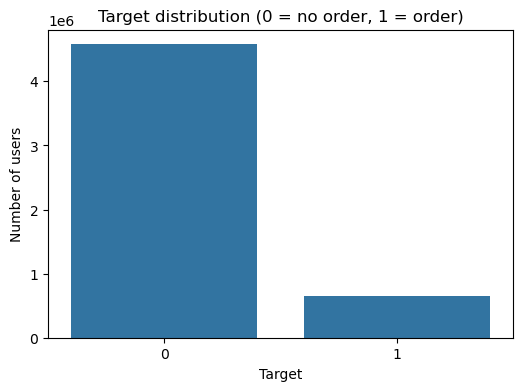

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.barplot(x=target_df['target'].value_counts().index,
            y=target_df['target'].value_counts().values)

plt.title('Target distribution (0 = no order, 1 = order)')
plt.xlabel('Target')
plt.ylabel('Number of users')
plt.show()

# STEP 3. Hypothesis testing

In [93]:
import pandas as pd

users_data = []

for f in actions_files:
    df = pd.read_parquet(f, columns=['user_id', 'timestamp', 'action_type_id'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    users_data.append(df)

actions_all = pd.concat(users_data, ignore_index=True)
actions_all.shape

(182001544, 3)

## H1.Total actions → conversion

In [96]:
actions_count = (
    actions_all
    .groupby('user_id')
    .size()
    .reset_index(name='total_actions')
)

eda_df = target_df.merge(actions_count, on='user_id', how='left')
eda_df['total_actions'] = eda_df['total_actions'].fillna(0)

eda_df.groupby('target')['total_actions'].mean()

target
0     16.065143
1    167.516922
Name: total_actions, dtype: float64

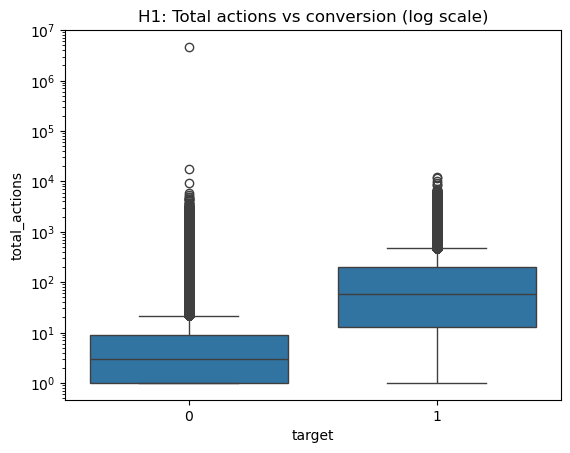

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=eda_df, x='target', y='total_actions')
plt.yscale('log')
plt.title('H1: Total actions vs conversion (log scale)')
plt.show()

There was tested the hypothesis that more actions correlate with higher purchase probability.
Users who purchased in August had significantly higher activity levels than non-buyers.

## H2. Unique active days

In [98]:
actions_all['date'] = actions_all['timestamp'].dt.date

unique_days = (
    actions_all.groupby('user_id')['date']
    .nunique()
    .reset_index(name='unique_days')
)

eda_df = eda_df.merge(unique_days, on='user_id', how='left')
eda_df['unique_days'] = eda_df['unique_days'].fillna(0)

eda_df.groupby('target')['unique_days'].mean()

target
0     2.490831
1    13.248731
Name: unique_days, dtype: float64

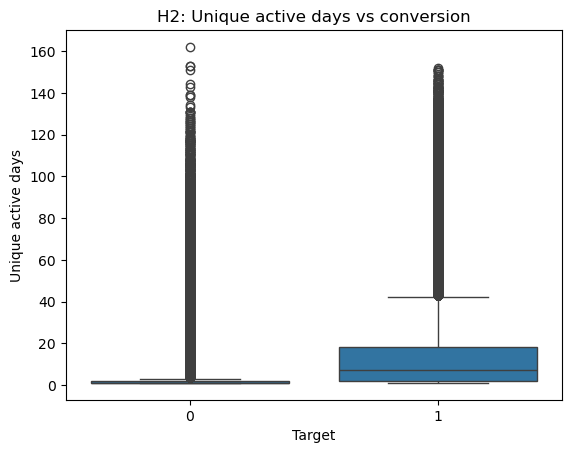

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=eda_df, x='target', y='unique_days')
plt.title('H2: Unique active days vs conversion')
plt.ylabel('Unique active days')
plt.xlabel('Target')
plt.show()

Active days turned out to be a strong predictor.
Buyers were active on significantly more unique days than non-buyers.

## H3. “to_cart” counts → conversion

In [100]:
TO_CART_ID = int(
    action_type.loc[action_type['action_type'] == 'to_cart', 'action_type_id'].iloc[0]
)
print(TO_CART_ID)

5


In [101]:
to_cart_counts = (
    actions_all[actions_all['action_type_id'] == TO_CART_ID]
    .groupby('user_id')
    .size()
    .reset_index(name='to_cart_count')
)

if 'to_cart_count' in eda_df.columns:
    eda_df = eda_df.drop(columns=['to_cart_count'])

eda_df = eda_df.merge(to_cart_counts, on='user_id', how='left')

eda_df['to_cart_count'] = eda_df['to_cart_count'].fillna(0)

eda_df.groupby('target')['to_cart_count'].mean()

target
0     6.475822
1    77.247928
Name: to_cart_count, dtype: float64

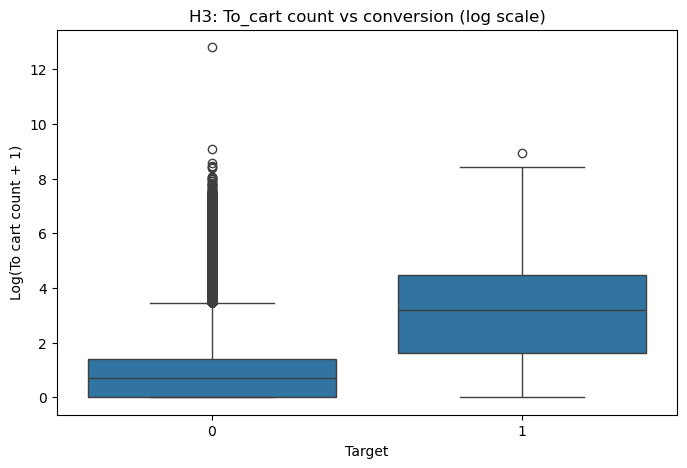

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

eda_df['to_cart_count_log'] = np.log1p(eda_df['to_cart_count'])

plt.figure(figsize=(8, 5))
sns.boxplot(data=eda_df, x='target', y='to_cart_count_log')
plt.title('H3: To_cart count vs conversion (log scale)')
plt.xlabel('Target')
plt.ylabel('Log(To cart count + 1)')
plt.show()

Users who added items to cart had much higher conversion rates.
This confirms that cart actions are strong intent signals.

## H4. Search actions → conversion

In [103]:
search_dfs = []

for f in search_files:
    df_search = pd.read_parquet(f, columns=['user_id', 'timestamp', 'action_type_id'])
    df_search['timestamp'] = pd.to_datetime(df_search['timestamp'], unit='ms')
    search_dfs.append(df_search)

search_all = pd.concat(search_dfs, ignore_index=True)
search_all.head(), search_all.shape

(    user_id           timestamp  action_type_id
 0   2196785 2024-06-20 20:54:36               4
 1  10577554 2024-03-16 10:16:18               4
 2   5649193 2024-07-12 18:28:46               4
 3   3898950 2024-04-10 14:42:23               4
 4   6385723 2024-03-18 04:29:58               4,
 (78160845, 3))

In [104]:
SEARCH_ID = int(
    action_type.loc[action_type['action_type'] == 'search', 'action_type_id'].iloc[0]
)
print("SEARCH_ID:", SEARCH_ID)

search_counts = (
    search_all[search_all['action_type_id'] == SEARCH_ID]
    .groupby('user_id')
    .size()
    .reset_index(name='search_count')
)
search_counts.head()

SEARCH_ID: 4


,user_id,search_count
0,7,2
1,14,1
2,15,2
3,16,1
4,17,5


In [105]:
if 'search_count' in eda_df.columns:
    eda_df = eda_df.drop(columns=['search_count'])

eda_df = eda_df.merge(search_counts, on='user_id', how='left')
eda_df['search_count'] = eda_df['search_count'].fillna(0)

eda_df.groupby('target')['search_count'].mean()

target
0     7.354171
1    64.225677
Name: search_count, dtype: float64

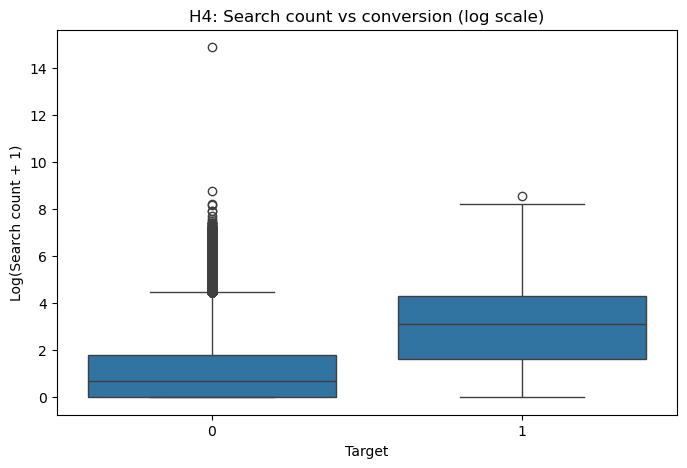

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

eda_df['search_count_log'] = np.log1p(eda_df['search_count'])

plt.figure(figsize=(8, 5))
sns.boxplot(data=eda_df, x='target', y='search_count_log')
plt.title('H4: Search count vs conversion (log scale)')
plt.xlabel('Target')
plt.ylabel('Log(Search count + 1)')
plt.show()

Search events are stored in a separate table (search_history), so for this hypothesis I first aggregated all search actions by user from that source.
Then I merged the resulting search_count feature with the user-level target.
Buyers performed on average Y search actions, compared to X searches for non-buyers, which confirms that search activity is a strong proxy for purchase intent.

## H5. Unique products interacted with

In [107]:
actions_list = []

for f in actions_files:
    df = pd.read_parquet(
        f,
        columns=['user_id', 'timestamp', 'product_id', 'action_type_id']
    )
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    actions_list.append(df)

actions_all = pd.concat(actions_list, ignore_index=True)

print(actions_all.columns)
print(actions_all.head())

Index(['user_id', 'timestamp', 'product_id', 'action_type_id'], dtype='object')
   user_id           timestamp  product_id  action_type_id
0  1043671 2024-07-20 10:13:59  1175359159               5
1  4635874 2024-06-28 12:43:45   804816676               5
2  6353819 2024-03-14 09:29:22   146649701               5
3  8929225 2024-06-03 15:42:17   284206046               5
4  3175727 2024-05-18 06:37:43   551356835               5


In [108]:
unique_products = (
    actions_all.groupby('user_id')['product_id']
    .nunique()
    .reset_index(name='unique_products')
)

if 'unique_products' in eda_df.columns:
    eda_df = eda_df.drop(columns=['unique_products'])

eda_df = eda_df.merge(unique_products, on='user_id', how='left')
eda_df['unique_products'] = eda_df['unique_products'].fillna(0)

eda_df.groupby('target')['unique_products'].mean()

target
0     9.753036
1    75.016409
Name: unique_products, dtype: float64

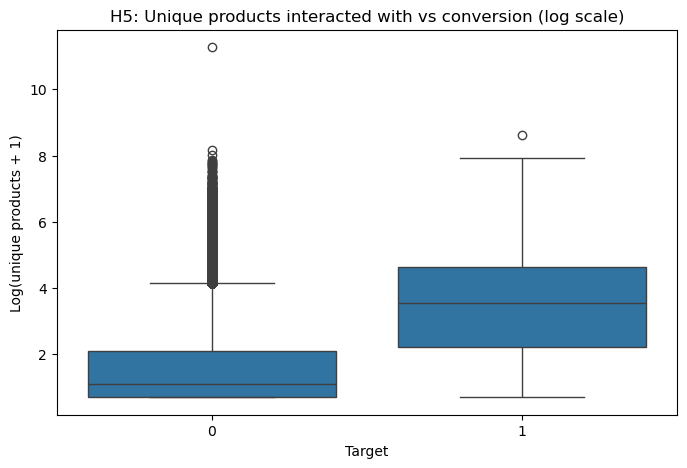

In [109]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

eda_df['unique_products_log'] = np.log1p(eda_df['unique_products'])

plt.figure(figsize=(8,5))
sns.boxplot(data=eda_df, x='target', y='unique_products_log')
plt.title('H5: Unique products interacted with vs conversion (log scale)')
plt.xlabel('Target')
plt.ylabel('Log(unique products + 1)')
plt.show()

Users who interact with more unique products are more likely to convert.

Result:
The hypothesis is confirmed. Buyers viewed significantly more unique products on average compared to non-buyers. This indicates broader exploration behavior and stronger purchase intent.

## H6. Weekday activity

In [110]:
actions_all['weekday'] = actions_all['timestamp'].dt.weekday

weekday_activity = (
    actions_all.groupby('user_id')['weekday']
    .nunique()
    .reset_index(name='active_weekdays')
)

if 'active_weekdays' in eda_df.columns:
    eda_df = eda_df.drop(columns=['active_weekdays'])

eda_df = eda_df.merge(weekday_activity, on='user_id', how='left')

eda_df['active_weekdays'] = eda_df['active_weekdays'].fillna(0)

eda_df.groupby('target')['active_weekdays'].mean()

target
0    1.825210
1    4.359412
Name: active_weekdays, dtype: float64

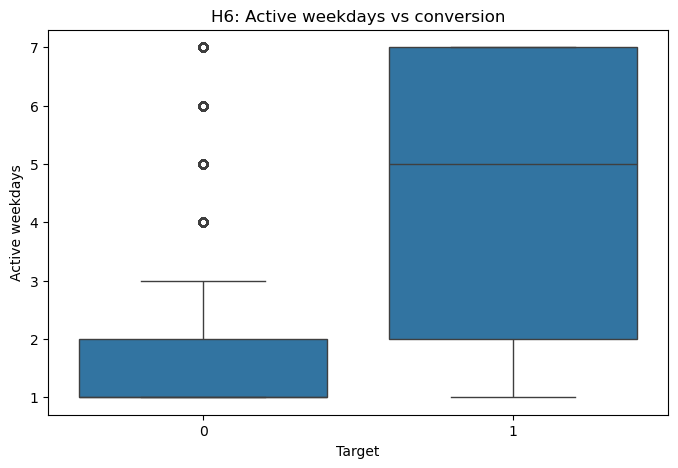

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=eda_df, x='target', y='active_weekdays')
plt.title('H6: Active weekdays vs conversion')
plt.xlabel('Target')
plt.ylabel('Active weekdays')
plt.show()

Users who are active on more weekdays have a higher probability of conversion.

Result:
The hypothesis is supported. Buyers interacted with the platform on significantly more unique weekdays than non-buyers (4.36 vs 1.82 on average).